In [136]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [137]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [138]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [139]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Rosacea


100%|██████████| 100/100 [00:03<00:00, 29.40it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [140]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [141]:
def equalize_histogram(img):
    return cv.equalizeHist(img)

In [142]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [143]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [144]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [145]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [146]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [147]:
import numpy as np

def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result


In [148]:
def gaussian_blur(img, ksize=3, sigma=0.3):
    return cv.GaussianBlur(img, (ksize, ksize), sigma)


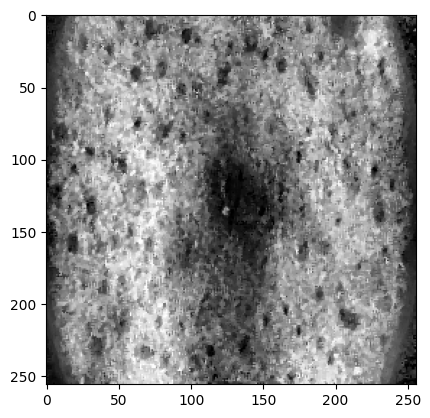

In [149]:

resize_img = resize_image(images[10])
gray_img = gray_scaling(resize_img)
clahe_img = manual_clahe(gray_img, 5, (4, 4))
kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
sharpened = cv.filter2D(clahe_img, -1, kernel)
medianData = median_filtering(sharpened)  
normalize_img = normalize(medianData)

plt.imshow(normalize_img, cmap="gray")



In [150]:
dataPreprocessed = []

for i in range(len(images)):
    resize_img = resize_image(images[i])
    gray_img = gray_scaling(resize_img)
    clahe_img = manual_clahe(gray_img, 5, (4, 4))
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv.filter2D(clahe_img, -1, kernel)
    medianData = median_filtering(sharpened)  
    normalize_img = normalize(sharpened)

    dataPreprocessed.append(normalize_img)


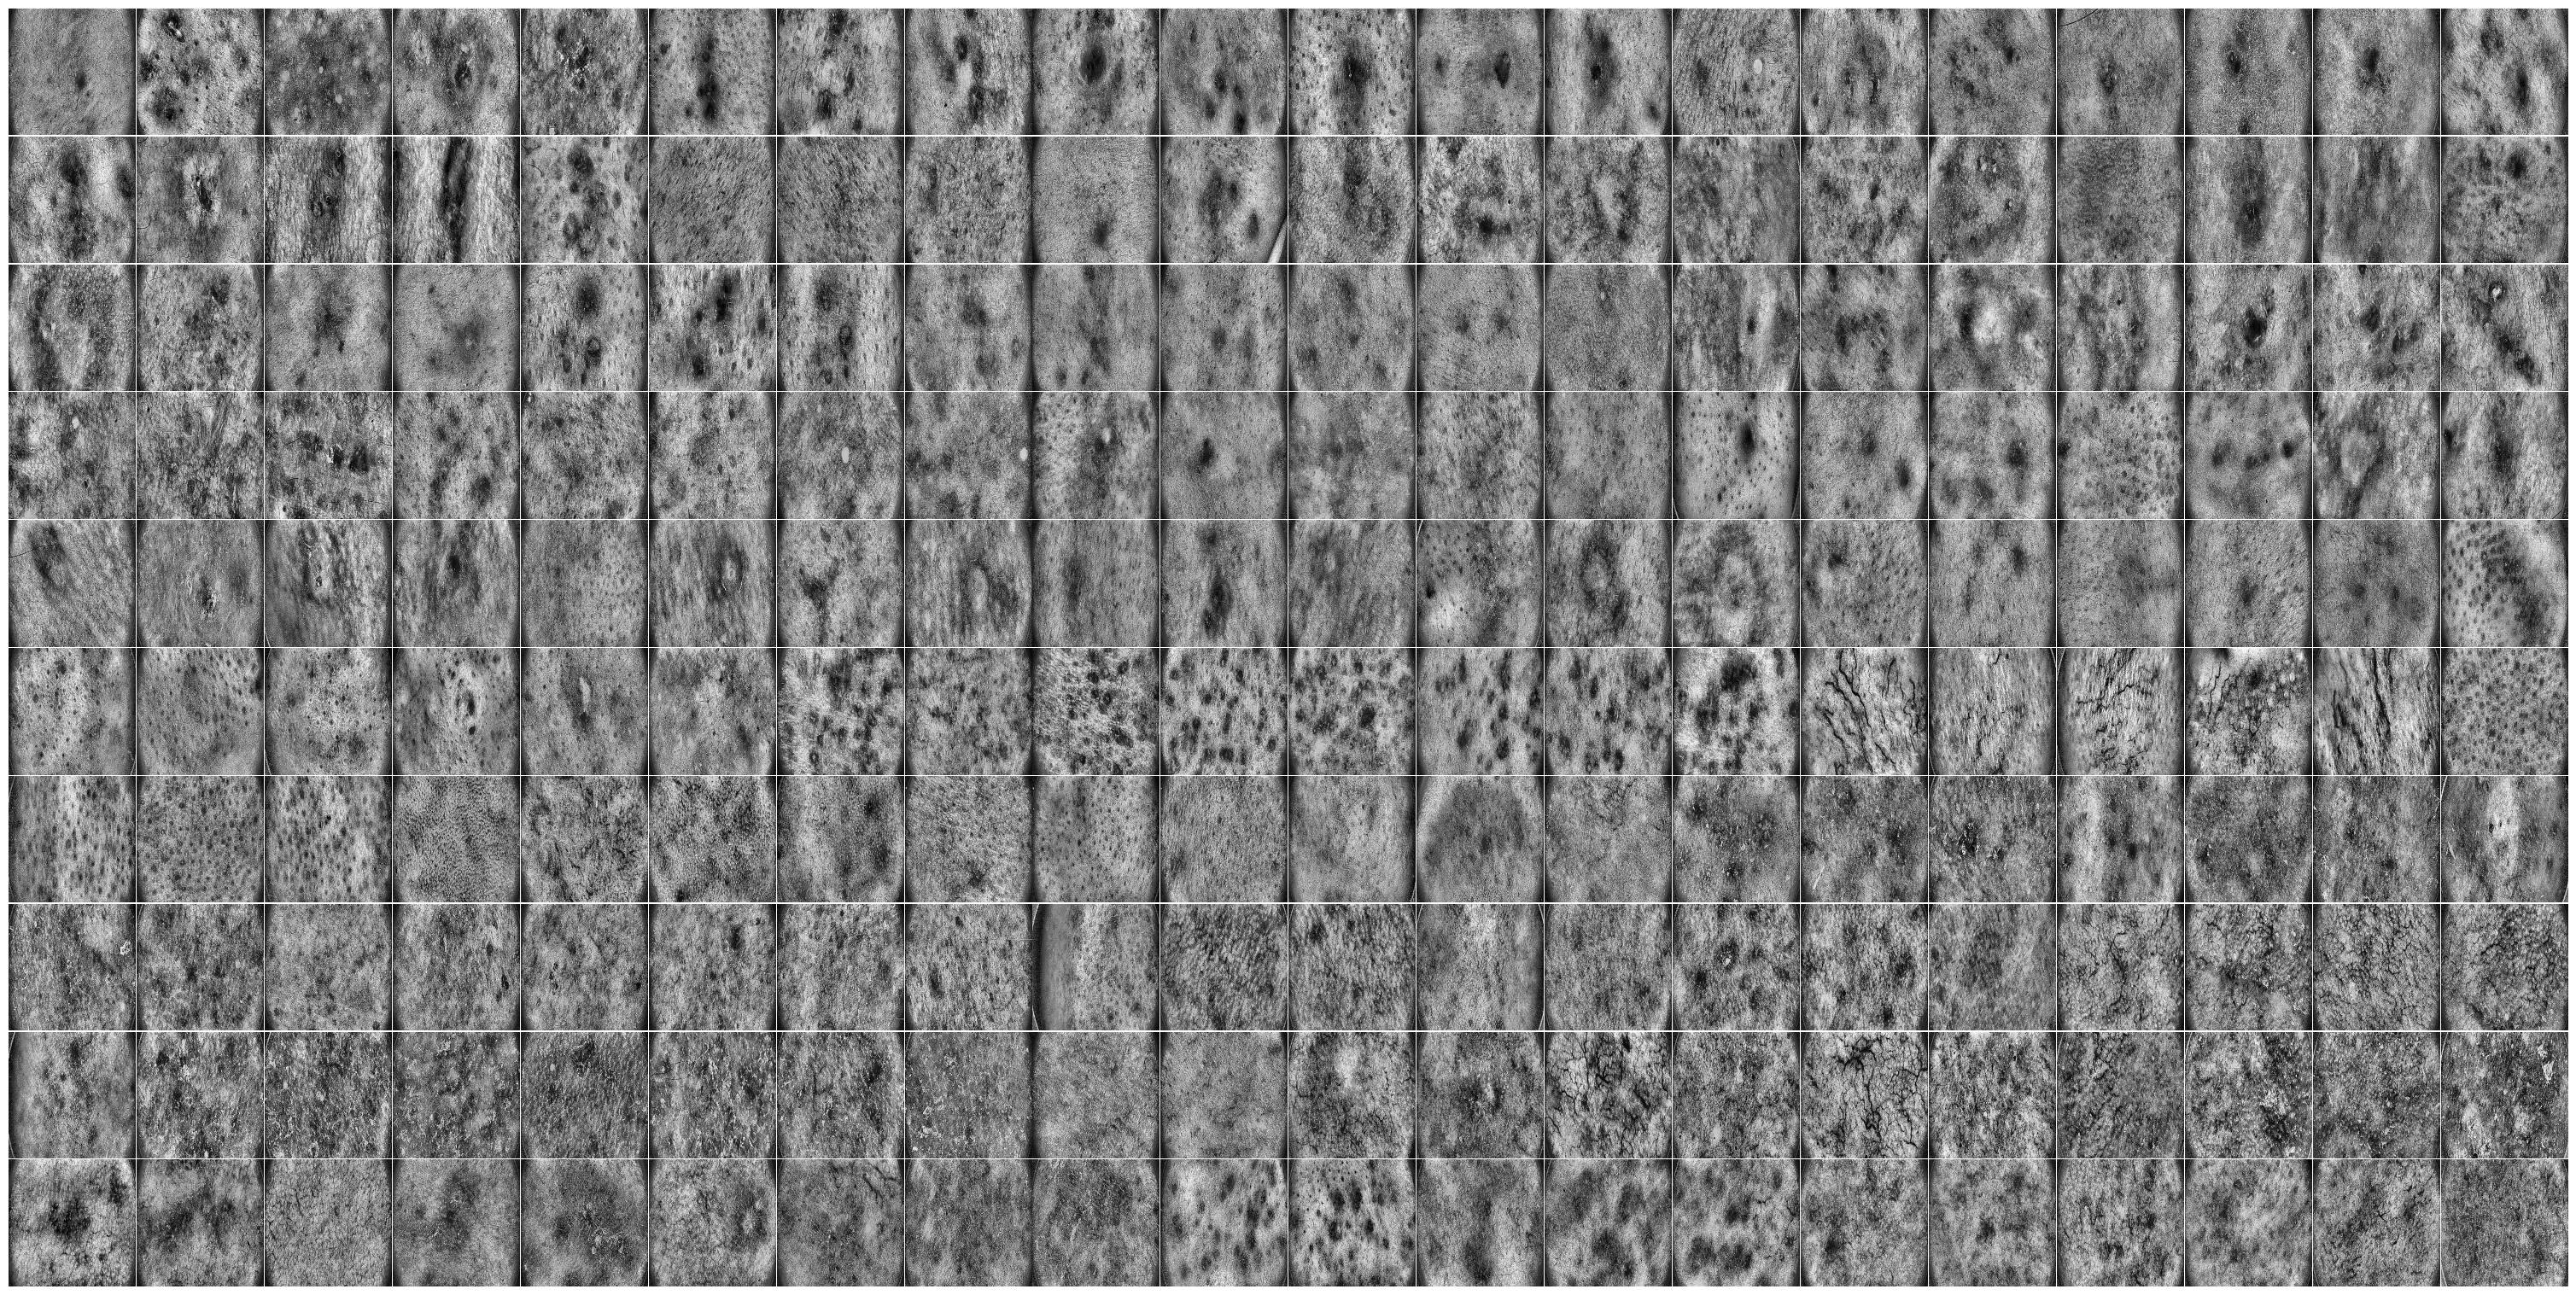

In [151]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [152]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [153]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [154]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [155]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [156]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [157]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [158]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [159]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [160]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [161]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [162]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [163]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [164]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [165]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [166]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [167]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [168]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [169]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


<h1>CSV</h1>

In [179]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_6.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_6.csv')
hasilEkstrak

Filename          Label     Contrast0    Contrast45    Contrast90  \
0    101_5.jpg  Acne Vulgaris  10477.790947   7868.301607   9958.864859   
1    102_2.jpg  Acne Vulgaris  10097.685034   7566.957386   9670.200199   
2    103_2.jpg  Acne Vulgaris  11669.268658   9103.316463  10022.224923   
3    106_1.jpg  Acne Vulgaris  12042.807721   9501.199062  10424.460003   
4    106_7.jpg  Acne Vulgaris  11204.532506   8980.388558   9322.716069   
..         ...            ...           ...           ...           ...   
195  118_2.jpg        Rosacea   9786.539139   7366.997970   9095.217647   
196  118_3.jpg        Rosacea  12177.743581   9661.765198   9682.863680   
197  118_4.jpg        Rosacea  11590.713143   8749.238785  10454.738373   
198  119_1.jpg        Rosacea  11471.940824   9558.740930   9596.329795   
199  119_2.jpg        Rosacea  13206.929320  10758.191972  11597.823024   

      Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     7835.169058      0.017054       0.024274       0.018561        0.024536   
1     8834.295794      0.028000       0.043957       0.029343        0.035664   
2     9053.913618      0.020965       0.033403       0.031414        0.034042   
3     8982.630481      0.023217       0.037479       0.033063        0.040268   
4     8507.826851      0.021054       0.030575       0.034903        0.034860   
..            ...           ...            ...            ...             ...   
195   7548.736578      0.015668       0.025494       0.018732        0.023818   
196   9633.665267      0.019816       0.032660       0.033253        0.032731   
197   8716.013256      0.018420       0.031540       0.023726        0.032081   
198   8973.032065      0.019875       0.028053       0.031263        0.031723   
199  10547.567982      0.022821       0.036216       0.033904        0.039107   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.000134  0.000112  0.011719  0.010630  0.011566   0.010576   
1    ...  0.000324  0.000363  0.017426  0.023197  0.017986   0.019062   
2    ...  0.000424  0.000437  0.019989  0.020721  0.020591   0.020916   
3    ...  0.000443  0.000505  0.021286  0.021651  0.021046   0.022477   
4    ...  0.000392  0.000374  0.018893  0.017526  0.019798   0.019345   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.000087  0.000099  0.009711  0.010443  0.009301   0.009929   
196  ...  0.000369  0.000335  0.018491  0.018312  0.019214   0.018306   
197  ...  0.000267  0.000267  0.016661  0.016339  0.016346   0.016350   
198  ...  0.000331  0.000344  0.016372  0.016709  0.018203   0.018535   
199  ...  0.000648  0.000668  0.025433  0.025303  0.025465   0.025849   

     Correlation0  Correlation45  Correlation90  Correlation135  
0       -0.073599       0.194218      -0.016060        0.197589  
1        0.179463       0.385092       0.215939        0.282087  
2       -0.057800       0.173534       0.090874        0.178021  
3        0.013545       0.220962       0.146733        0.263480  
4        0.009415       0.205755       0.176593        0.247548  
..            ...            ...            ...             ...  
195      0.030085       0.269864       0.100683        0.251856  
196      0.012018       0.216197       0.215675        0.218482  
197     -0.009531       0.237700       0.090855        0.240584  
198      0.006717       0.172173       0.169609        0.222893  
199     -0.069137       0.129249       0.061443        0.146302  

[200 rows x 30 columns]

<Axes: >

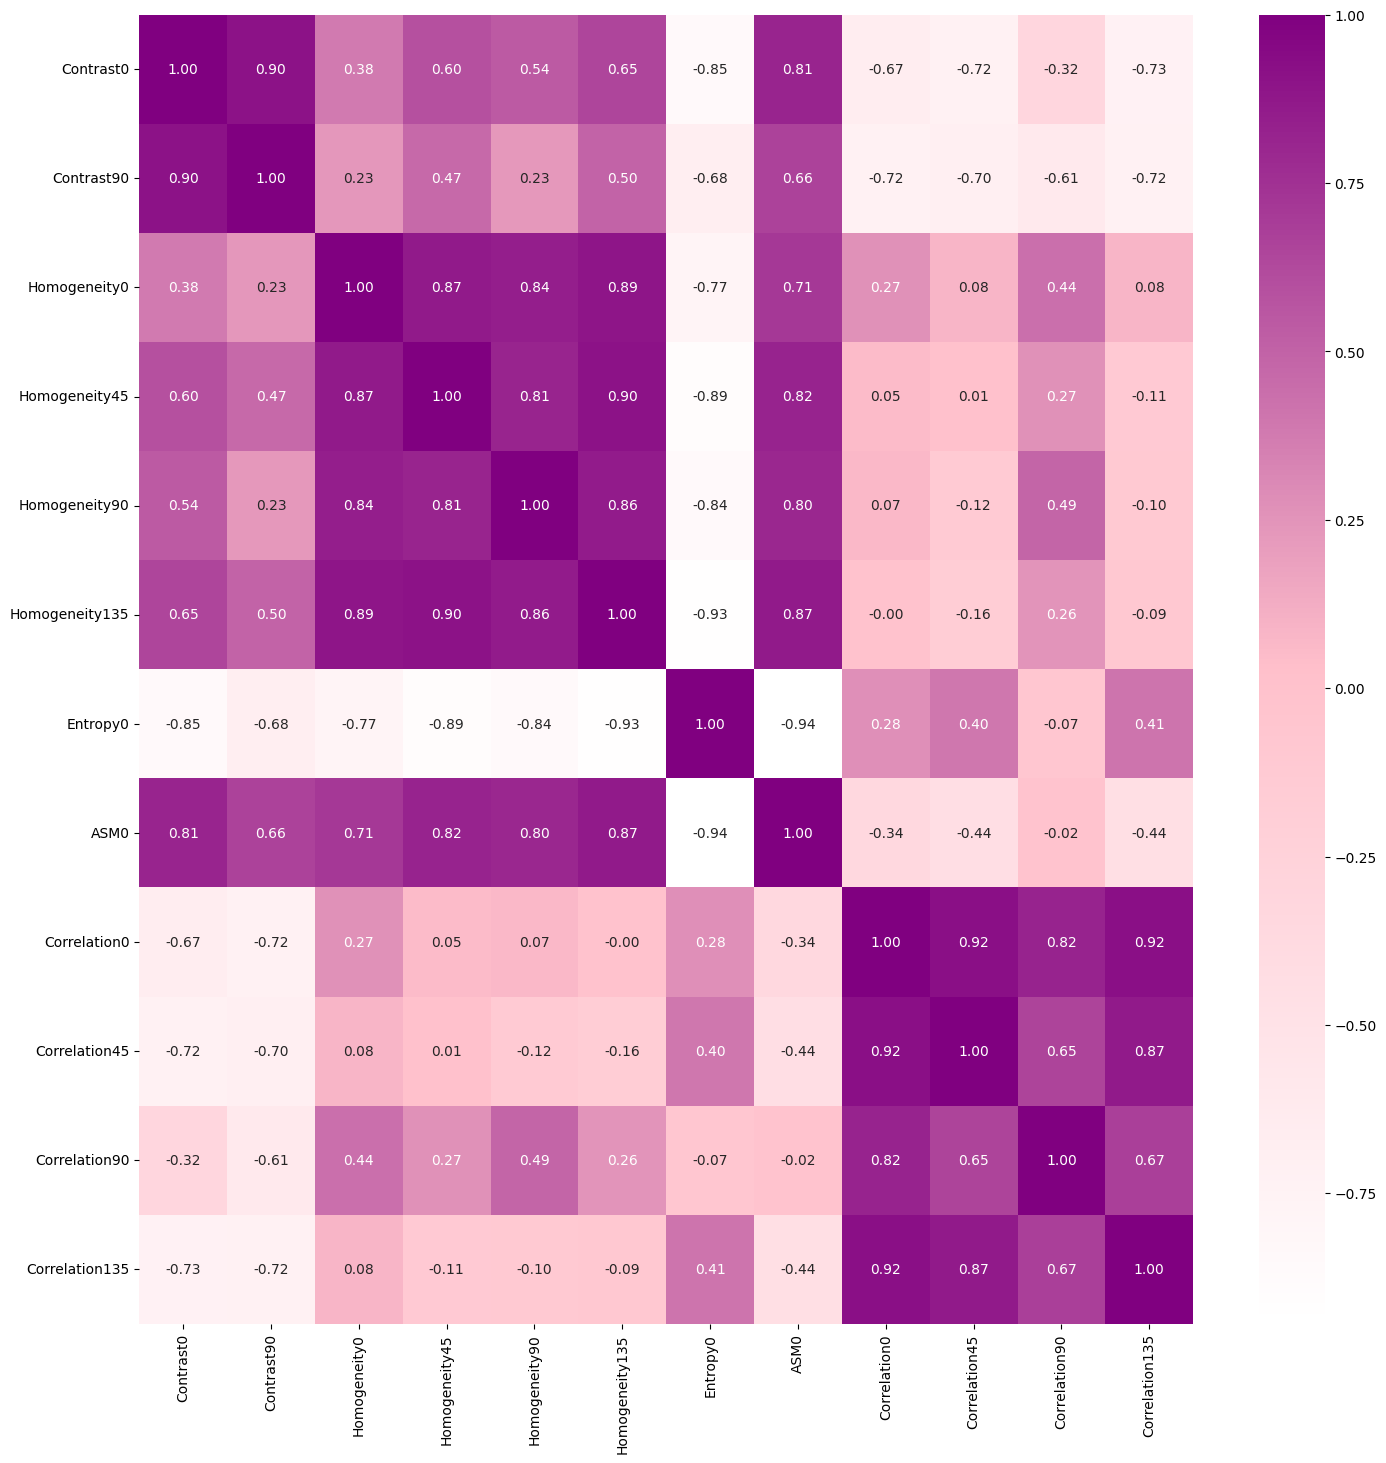

In [180]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [181]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 12)
(40, 12)


In [182]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [174]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [175]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------RANDOM FOREST------")
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------RANDOM FOREST------
------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.95      0.97      0.96        79
      Rosacea       0.97      0.95      0.96        81

     accuracy                           0.96       160
    macro avg       0.96      0.96      0.96       160
 weighted avg       0.96      0.96      0.96       160

[[77  2]
 [ 4 77]]
Accuracy: 0.9625

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.60      0.57      0.59        21
      Rosacea       0.55      0.58      0.56        19

     accuracy                           0.57        40
    macro avg       0.57      0.58      0.57        40
 weighted avg       0.58      0.57      0.58        40

[[12  9]
 [ 8 11]]
Accuracy: 0.575


In [176]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------SVM------")
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

------SVM------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.70      0.72      0.71        79
      Rosacea       0.72      0.70      0.71        81

     accuracy                           0.71       160
    macro avg       0.71      0.71      0.71       160
 weighted avg       0.71      0.71      0.71       160

[[57 22]
 [24 57]]
Accuracy: 0.7125

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.68      0.71      0.70        21
      Rosacea       0.67      0.63      0.65        19

     accuracy                           0.68        40
    macro avg       0.67      0.67      0.67        40
 weighted avg       0.67      0.68      0.67        40

[[15  6]
 [ 7 12]]
Accuracy: 0.675


In [177]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------KNN------")
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

------KNN------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.72      0.70      0.71        79
      Rosacea       0.71      0.74      0.73        81

     accuracy                           0.72       160
    macro avg       0.72      0.72      0.72       160
 weighted avg       0.72      0.72      0.72       160

[[55 24]
 [21 60]]
Accuracy: 0.71875

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.56      0.48      0.51        21
      Rosacea       0.50      0.58      0.54        19

     accuracy                           0.53        40
    macro avg       0.53      0.53      0.52        40
 weighted avg       0.53      0.53      0.52        40

[[10 11]
 [ 8 11]]
Accuracy: 0.525


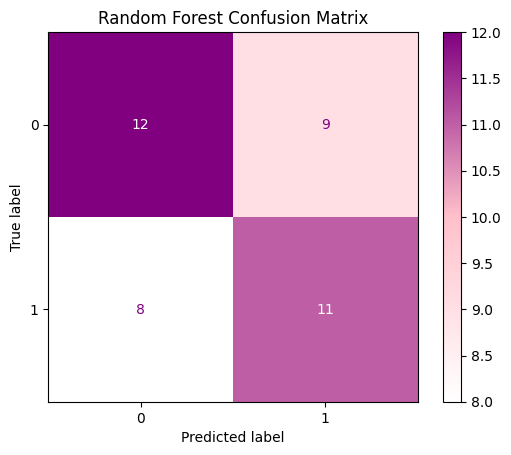

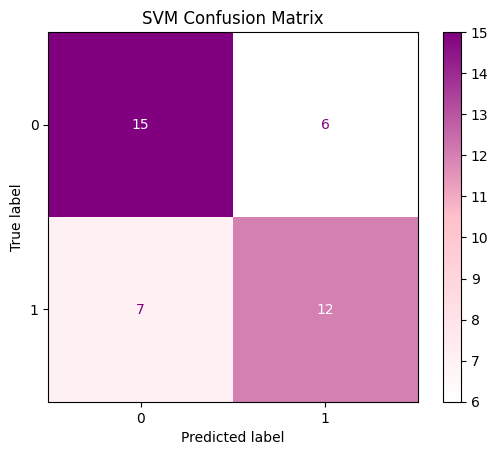

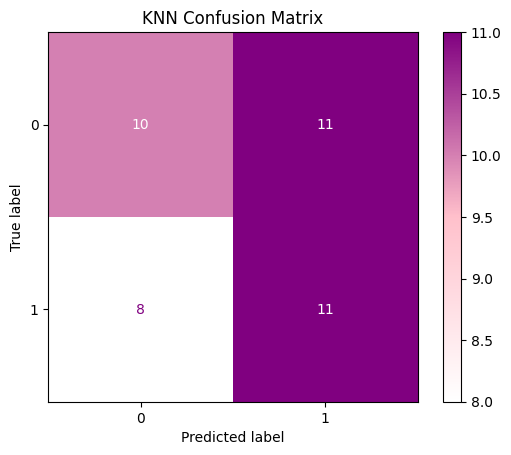

In [178]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")